In [14]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

## Set up parameters, create isochrone grid

In [15]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.MISTv1()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F182M']
filters = ['m_jwst_F115W', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

In [16]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma1p0/fiducial/sfe_ff100/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 1.5)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()

# read ages for simulated stars
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass        isMultiple        compMass            systemMass             e                log_a               age        
------------------- ---------- --------------------- ------------------- ------------------ ------------------ ------------------
  56.24521950614411        0.0                    []   56.24521950614411                nan                nan  1.494411190854979
0.11411525852041825        0.0                    [] 0.11411525852041825                nan                nan 1.5011385289993755
  12.96283688892593        0.0                    []   12.96283688892593                nan                nan 1.4970749668953602
0.27321673034539384        0.0                    [] 0.27321673034539384                nan                nan 1.4964816285263873
                ...        ...                   ...                 ...                ...                ...                ...
0.20449300038109305        1.0 [0.11248395795903553] 0.31697695834012857   0.2989732941710

In [17]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 6.172382928762329
Max log age = 6.182058450993647
Min level age = 1487246.4082493563
Max level age = 1520752.191543579


In [18]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
print(compMasses)

1440
[0.16312509029104827, 0.09636490446440792, 0.03636643773183382, 0.21849298240279427, 0.03651675631669997, 0.019132423710002903, 0.05933243108388687, 0.12247264926103713, 0.6385500001324462, 0.2022302569658592, 0.07471903553293849, 0.16814292142663018, 0.0230523225129767, 0.1609042880961581, 0.2688387764755287, 0.05549755459546917, 0.012694034520736917, 0.09389877662294215, 0.024808470564410257, 0.012916016567435117, 0.537538199511473, 0.10166459547430746, 0.017003778368234634, 0.1895631651814792, 0.011007644292289143, 0.1908368021249771, 0.16246922314167023, 0.09223736189469771, 0.08370963329421344, 0.5588908545309716, 0.03431704460795354, 0.045772770042914156, 0.15501195511789118, 0.026778635366288318, 0.02533061849344048, 0.044663360767730004, 0.05472224588958281, 0.028879488831018898, 0.1309257580510967, 0.11610612932071074, 0.7052331632631441, 0.42965823402192654, 0.09028542237526906, 0.08645685263723765, 0.6922198305107939, 0.5510788138832429, 0.014685248829668424, 0.02854885

In [19]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[6.         6.17609126 6.30103   ]
[1000000. 1500000. 2000000.]


In [20]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


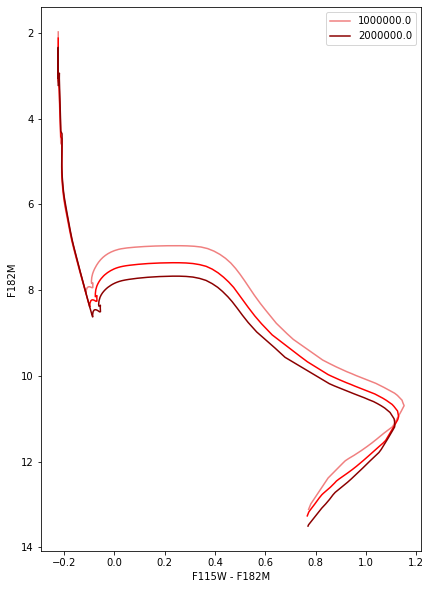

In [21]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [22]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/12-18')
import interpolatorExp as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
for i in range(len(stars)):
    print(stars[i])

Desired mass 0.07746465814392134 is outside the range of the isochrone.
Desired mass 0.07746465814392134 is outside the range of the isochrone.
Desired mass 0.08466339817270757 is outside the range of the isochrone.
Desired mass 0.08466339817270757 is outside the range of the isochrone.
Desired mass 0.08217508690946722 is outside the range of the isochrone.
Desired mass 0.08217508690946722 is outside the range of the isochrone.
Desired mass 0.09649129577108034 is outside the range of the isochrone.
Desired mass 0.09649129577108034 is outside the range of the isochrone.
Desired mass 0.0428821459115702 is outside the range of the isochrone.
Desired mass 0.0428821459115702 is outside the range of the isochrone.
Desired mass 0.09262585734238067 is outside the range of the isochrone.
Desired mass 0.09262585734238067 is outside the range of the isochrone.
Desired mass 0.07831495046053252 is outside the range of the isochrone.
Desired mass 0.07831495046053252 is outside the range of the isoch

Desired mass 0.08088651299476624 is outside the range of the isochrone.
Desired mass 0.08088651299476624 is outside the range of the isochrone.
Desired mass 0.08690374344587326 is outside the range of the isochrone.
Desired mass 0.08690374344587326 is outside the range of the isochrone.
Desired mass 0.04618830310476292 is outside the range of the isochrone.
Desired mass 0.04618830310476292 is outside the range of the isochrone.
Desired mass 0.10137251131754645 is outside the range of the isochrone.
Desired mass 0.10137251131754645 is outside the range of the isochrone.
Desired mass 0.020629298243096294 is outside the range of the isochrone.
Desired mass 0.020629298243096294 is outside the range of the isochrone.
Desired mass 0.03014186935521681 is outside the range of the isochrone.
Desired mass 0.03014186935521681 is outside the range of the isochrone.
Desired mass 0.10097900469865115 is outside the range of the isochrone.
Desired mass 0.10097900469865115 is outside the range of the i

Desired mass 0.029854124575104387 is outside the range of the isochrone.
Desired mass 0.07529969342834267 is outside the range of the isochrone.
Desired mass 0.07529969342834267 is outside the range of the isochrone.
Desired mass 0.03321996433615414 is outside the range of the isochrone.
Desired mass 0.03321996433615414 is outside the range of the isochrone.
Desired mass 0.024887728241640764 is outside the range of the isochrone.
Desired mass 0.024887728241640764 is outside the range of the isochrone.
Desired mass 0.07030582510651515 is outside the range of the isochrone.
Desired mass 0.07030582510651515 is outside the range of the isochrone.
Desired mass 0.072721884219865 is outside the range of the isochrone.
Desired mass 0.072721884219865 is outside the range of the isochrone.
Desired mass 0.028232072062169017 is outside the range of the isochrone.
Desired mass 0.028232072062169017 is outside the range of the isochrone.
Desired mass 0.017976957685676934 is outside the range of the i

Desired mass 0.05590752081313288 is outside the range of the isochrone.
Desired mass 0.05590752081313288 is outside the range of the isochrone.
Desired mass 0.04186760773078396 is outside the range of the isochrone.
Desired mass 0.04186760773078396 is outside the range of the isochrone.
Desired mass 0.10394257429068404 is outside the range of the isochrone.
Desired mass 0.0398230722145917 is outside the range of the isochrone.
Desired mass 0.0398230722145917 is outside the range of the isochrone.
Desired mass 0.060726409282566285 is outside the range of the isochrone.
Desired mass 0.060726409282566285 is outside the range of the isochrone.
Desired mass 0.09597769468099064 is outside the range of the isochrone.
Desired mass 0.09597769468099064 is outside the range of the isochrone.
Desired mass 0.08737486599245232 is outside the range of the isochrone.
Desired mass 0.08737486599245232 is outside the range of the isochrone.
Desired mass 0.05432633084084501 is outside the range of the iso

Desired mass 0.022921036788939725 is outside the range of the isochrone.
Desired mass 0.022921036788939725 is outside the range of the isochrone.
Desired mass 0.04525111574527417 is outside the range of the isochrone.
Desired mass 0.04525111574527417 is outside the range of the isochrone.
Desired mass 0.057441554963588715 is outside the range of the isochrone.
Desired mass 0.057441554963588715 is outside the range of the isochrone.
Desired mass 0.0389019250869751 is outside the range of the isochrone.
Desired mass 0.0389019250869751 is outside the range of the isochrone.
Desired mass 0.03050566306868856 is outside the range of the isochrone.
Desired mass 0.03050566306868856 is outside the range of the isochrone.
Desired mass 0.09011413458878026 is outside the range of the isochrone.
Desired mass 0.09011413458878026 is outside the range of the isochrone.
Desired mass 0.06536628690746739 is outside the range of the isochrone.
Desired mass 0.06536628690746739 is outside the range of the i

Desired mass 0.0457934361065272 is outside the range of the isochrone.
Desired mass 0.0457934361065272 is outside the range of the isochrone.
Desired mass 0.07992207726711047 is outside the range of the isochrone.
Desired mass 0.07992207726711047 is outside the range of the isochrone.
Desired mass 0.061464493282614496 is outside the range of the isochrone.
Desired mass 0.061464493282614496 is outside the range of the isochrone.
Desired mass 0.08205333054087445 is outside the range of the isochrone.
Desired mass 0.08205333054087445 is outside the range of the isochrone.
Desired mass 0.06990013795684719 is outside the range of the isochrone.
Desired mass 0.06990013795684719 is outside the range of the isochrone.
Desired mass 0.05219460916189535 is outside the range of the isochrone.
Desired mass 0.05219460916189535 is outside the range of the isochrone.
Desired mass 0.09717236913339591 is outside the range of the isochrone.
Desired mass 0.09717236913339591 is outside the range of the iso

Desired mass 0.06864934876118602 is outside the range of the isochrone.
Desired mass 0.06864934876118602 is outside the range of the isochrone.
Desired mass 0.09912453738708661 is outside the range of the isochrone.
Desired mass 0.09912453738708661 is outside the range of the isochrone.
Desired mass 0.030788843415302136 is outside the range of the isochrone.
Desired mass 0.030788843415302136 is outside the range of the isochrone.
Desired mass 0.03390163551254083 is outside the range of the isochrone.
Desired mass 0.03390163551254083 is outside the range of the isochrone.
Desired mass 0.051497568831153404 is outside the range of the isochrone.
Desired mass 0.051497568831153404 is outside the range of the isochrone.
Desired mass 0.040106125994474516 is outside the range of the isochrone.
Desired mass 0.040106125994474516 is outside the range of the isochrone.
Desired mass 0.04131991826612342 is outside the range of the isochrone.
Desired mass 0.04131991826612342 is outside the range of t

Desired mass 0.02237263246138714 is outside the range of the isochrone.
Desired mass 0.02237263246138714 is outside the range of the isochrone.
Desired mass 0.07592809069702598 is outside the range of the isochrone.
Desired mass 0.07592809069702598 is outside the range of the isochrone.
Desired mass 0.03344305571574868 is outside the range of the isochrone.
Desired mass 0.03344305571574868 is outside the range of the isochrone.
Desired mass 0.07101752093711991 is outside the range of the isochrone.
Desired mass 0.07101752093711991 is outside the range of the isochrone.
Desired mass 0.04987139555537223 is outside the range of the isochrone.
Desired mass 0.04987139555537223 is outside the range of the isochrone.
Desired mass 0.058100276042000056 is outside the range of the isochrone.
Desired mass 0.058100276042000056 is outside the range of the isochrone.
Desired mass 0.031073097814164636 is outside the range of the isochrone.
Desired mass 0.031073097814164636 is outside the range of the

Desired mass 0.011808213641946919 is outside the range of the isochrone.
Desired mass 0.011808213641946919 is outside the range of the isochrone.
Desired mass 0.011780242462414306 is outside the range of the isochrone.
Desired mass 0.011780242462414306 is outside the range of the isochrone.
Desired mass 0.092327054412227 is outside the range of the isochrone.
Desired mass 0.092327054412227 is outside the range of the isochrone.
Desired mass 0.07885671279022805 is outside the range of the isochrone.
Desired mass 0.07885671279022805 is outside the range of the isochrone.
Desired mass 0.0948112707088174 is outside the range of the isochrone.
Desired mass 0.0948112707088174 is outside the range of the isochrone.
Desired mass 0.09078492615084156 is outside the range of the isochrone.
Desired mass 0.09078492615084156 is outside the range of the isochrone.
Desired mass 0.06795864969373745 is outside the range of the isochrone.
Desired mass 0.06795864969373745 is outside the range of the isoch

Desired mass 0.025305122186674134 is outside the range of the isochrone.
Desired mass 0.025305122186674134 is outside the range of the isochrone.
Desired mass 0.036213668477602344 is outside the range of the isochrone.
Desired mass 0.036213668477602344 is outside the range of the isochrone.
Desired mass 0.07887679044140097 is outside the range of the isochrone.
Desired mass 0.07887679044140097 is outside the range of the isochrone.
Desired mass 0.053260721357716104 is outside the range of the isochrone.
Desired mass 0.053260721357716104 is outside the range of the isochrone.
Desired mass 0.08989125681489678 is outside the range of the isochrone.
Desired mass 0.08989125681489678 is outside the range of the isochrone.
Desired mass 0.08273454151625959 is outside the range of the isochrone.
Desired mass 0.08273454151625959 is outside the range of the isochrone.
Desired mass 0.021989178182904166 is outside the range of the isochrone.
Desired mass 0.021989178182904166 is outside the range of

Desired mass 0.031791702328048045 is outside the range of the isochrone.
Desired mass 0.031791702328048045 is outside the range of the isochrone.
Desired mass 0.02726709423245245 is outside the range of the isochrone.
Desired mass 0.02726709423245245 is outside the range of the isochrone.
Desired mass 0.022578710394293044 is outside the range of the isochrone.
Desired mass 0.022578710394293044 is outside the range of the isochrone.
Desired mass 0.04700913295414384 is outside the range of the isochrone.
Desired mass 0.04700913295414384 is outside the range of the isochrone.
Desired mass 0.1023343928940826 is outside the range of the isochrone.
Desired mass 0.1023343928940826 is outside the range of the isochrone.
Desired mass 0.06739850922114254 is outside the range of the isochrone.
Desired mass 0.06739850922114254 is outside the range of the isochrone.
Desired mass 0.09746280039544065 is outside the range of the isochrone.
Desired mass 0.09746280039544065 is outside the range of the i

Desired mass 0.038650536999956096 is outside the range of the isochrone.
Desired mass 0.038650536999956096 is outside the range of the isochrone.
Desired mass 0.04340637346706991 is outside the range of the isochrone.
Desired mass 0.04340637346706991 is outside the range of the isochrone.
Desired mass 0.0695863838519715 is outside the range of the isochrone.
Desired mass 0.0695863838519715 is outside the range of the isochrone.
Desired mass 0.02543094065746848 is outside the range of the isochrone.
Desired mass 0.02543094065746848 is outside the range of the isochrone.
Desired mass 0.05979217927541907 is outside the range of the isochrone.
Desired mass 0.05979217927541907 is outside the range of the isochrone.
Desired mass 0.06319007922497423 is outside the range of the isochrone.
Desired mass 0.06319007922497423 is outside the range of the isochrone.
Desired mass 0.07051769373640783 is outside the range of the isochrone.
Desired mass 0.07051769373640783 is outside the range of the iso

Desired mass 0.06251229982991 is outside the range of the isochrone.
Desired mass 0.06251229982991 is outside the range of the isochrone.
Desired mass 0.05939656139170993 is outside the range of the isochrone.
Desired mass 0.05939656139170993 is outside the range of the isochrone.
Desired mass 0.02931163283596017 is outside the range of the isochrone.
Desired mass 0.02931163283596017 is outside the range of the isochrone.
Desired mass 0.04704210984443492 is outside the range of the isochrone.
Desired mass 0.04704210984443492 is outside the range of the isochrone.
Desired mass 0.033984860414599145 is outside the range of the isochrone.
Desired mass 0.033984860414599145 is outside the range of the isochrone.
Desired mass 0.05590989765909453 is outside the range of the isochrone.
Desired mass 0.05590989765909453 is outside the range of the isochrone.
Desired mass 0.012924594461765469 is outside the range of the isochrone.
Desired mass 0.012924594461765469 is outside the range of the isoch

Desired mass 0.05985740492817031 is outside the range of the isochrone.
Desired mass 0.05985740492817031 is outside the range of the isochrone.
Desired mass 0.08003283349859563 is outside the range of the isochrone.
Desired mass 0.08003283349859563 is outside the range of the isochrone.
Desired mass 0.012830863725706305 is outside the range of the isochrone.
Desired mass 0.012830863725706305 is outside the range of the isochrone.
Desired mass 0.01592489158291225 is outside the range of the isochrone.
Desired mass 0.01592489158291225 is outside the range of the isochrone.
Desired mass 0.021059727735743935 is outside the range of the isochrone.
Desired mass 0.021059727735743935 is outside the range of the isochrone.
Desired mass 0.09981193244319352 is outside the range of the isochrone.
Desired mass 0.09981193244319352 is outside the range of the isochrone.
Desired mass 0.03252210208887742 is outside the range of the isochrone.
Desired mass 0.03252210208887742 is outside the range of the

Desired mass 0.06989703019281279 is outside the range of the isochrone.
Desired mass 0.06989703019281279 is outside the range of the isochrone.
Desired mass 0.03853313641007861 is outside the range of the isochrone.
Desired mass 0.03853313641007861 is outside the range of the isochrone.
Desired mass 0.09654924284004035 is outside the range of the isochrone.
Desired mass 0.09654924284004035 is outside the range of the isochrone.
Desired mass 0.08807359889584822 is outside the range of the isochrone.
Desired mass 0.08807359889584822 is outside the range of the isochrone.
Desired mass 0.07923250503169696 is outside the range of the isochrone.
Desired mass 0.07923250503169696 is outside the range of the isochrone.
Desired mass 0.03628742553361701 is outside the range of the isochrone.
Desired mass 0.03628742553361701 is outside the range of the isochrone.
Desired mass 0.06153776614547904 is outside the range of the isochrone.
Desired mass 0.06153776614547904 is outside the range of the iso

Desired mass 0.03510456848040012 is outside the range of the isochrone.
Desired mass 0.03510456848040012 is outside the range of the isochrone.
Desired mass 0.10190177802289548 is outside the range of the isochrone.
Desired mass 0.10190177802289548 is outside the range of the isochrone.
Desired mass 0.03188450942160066 is outside the range of the isochrone.
Desired mass 0.03188450942160066 is outside the range of the isochrone.
Desired mass 0.013943339777357447 is outside the range of the isochrone.
Desired mass 0.013943339777357447 is outside the range of the isochrone.
Desired mass 0.04231069763318475 is outside the range of the isochrone.
Desired mass 0.04231069763318475 is outside the range of the isochrone.
Desired mass 0.05445120441756373 is outside the range of the isochrone.
Desired mass 0.05445120441756373 is outside the range of the isochrone.
Desired mass 0.05962385167307392 is outside the range of the isochrone.
Desired mass 0.05962385167307392 is outside the range of the i

None
[1.2613944744382193, 4343.075, 3.804, 11.248, 10.277]
[0.49131599231814466, 3781.806, 3.726, 12.138, 11.011]
[1.4052640919048052, 4411.241, 3.813, 11.143, 10.204]
None
None
[0.1927086420180411, 3342.145, 3.623, 12.961, 11.968]
None
[0.22913931645772148, 3403.423, 3.636, 12.804, 11.774]
[0.0712500900997139, 3015.292, 3.513, 13.891, 13.108]
[0.10069660858919921, 3112.349, 3.541, 13.559, 12.722]
[0.5688061618713592, 3865.133, 3.743, 12.008, 10.881]
[0.0796453491538788, 3041.427, 3.514, 13.781, 12.982]
[4.575827579316338, 5007.215, 3.802, 10.041, 9.347]
None
[0.5952898124897745, 3889.061, 3.744, 11.966, 10.84]
[0.8861440826552262, 4123.193, 3.778, 11.59, 10.524]
None
[1629.5560384704283, 20718.923, 4.284, 7.289, 7.432]
None
None
None
None
[0.5224209193266035, 3817.825, 3.734, 12.085, 10.956]
None
[0.10241097012574879, 3116.432, 3.54, 13.541, 12.702]
[0.626852647036737, 3919.439, 3.751, 11.919, 10.797]
None
[0.43799733369376365, 3715.848, 3.71, 12.235, 11.117]
None
[1.1360864248205986,

[0.46211174558540197, 3748.832, 3.72, 12.191, 11.069]
[0.08324533518976374, 3052.83, 3.517, 13.738, 12.934]
[0.292856497641114, 3509.928, 3.664, 12.591, 11.513]
[0.1365998711379427, 3222.863, 3.587, 13.274, 12.369]
None
[0.44995807806722393, 3734.178, 3.717, 12.213, 11.093]
None
None
None
[0.09086945757286252, 3078.228, 3.527, 13.656, 12.838]
[2.188387155710729, 4655.99, 3.827, 10.728, 9.9]
[0.3846579211969695, 3648.481, 3.698, 12.348, 11.242]
[0.06761360151050001, 3002.882, 3.512, 13.943, 13.167]
[0.12295535529195126, 3186.792, 3.575, 13.372, 12.494]
None
[0.22399471451986178, 3395.69, 3.635, 12.825, 11.8]
[0.31644974992966596, 3547.237, 3.673, 12.521, 11.435]
[0.12399272582046654, 3189.692, 3.576, 13.364, 12.484]
None
[0.14130693984234008, 3234.28, 3.592, 13.243, 12.329]
None
None
[1.302871042655636, 4365.19, 3.808, 11.217, 10.257]
[0.1751525592899774, 3309.259, 3.615, 13.048, 12.076]
None
[0.3635289475142848, 3618.267, 3.691, 12.398, 11.297]
None
[0.23226171634373904, 3408.794, 3.63

[0.09713685667052709, 3094.894, 3.528, 13.589, 12.763]
[0.4406704164352065, 3720.048, 3.712, 12.23, 11.112]
None
None
None
None
[0.14839124333358122, 3249.738, 3.594, 13.197, 12.269]
None
[0.15950055360680013, 3271.553, 3.596, 13.131, 12.185]
[0.08514291696879803, 3057.897, 3.517, 13.716, 12.908]
None
[0.06564627617106777, 2994.366, 3.508, 13.972, 13.2]
None
[0.0668249999016252, 2997.065, 3.506, 13.952, 13.18]
[4.52242995771896, 5002.313, 3.803, 10.052, 9.356]
[0.9757289959539189, 4180.418, 3.784, 11.497, 10.453]
None
None
None
[0.8623281442886442, 4105.994, 3.776, 11.616, 10.544]
[0.13092976350018168, 3206.114, 3.578, 13.311, 12.42]
[0.5158239090044054, 3808.324, 3.73, 12.095, 10.966]
None
[0.17432589762549633, 3305.772, 3.611, 13.051, 12.081]
None
[0.11344281338622537, 3155.762, 3.559, 13.446, 12.584]
[0.3130438955687528, 3539.478, 3.668, 12.53, 11.444]
[2.3668563449564406, 4688.034, 3.821, 10.652, 9.838]
None
None
None
None
[0.26861273946656533, 3465.297, 3.647, 12.664, 11.601]
[0.2

In [23]:
# perform interpolation on companion stars
companions = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

for i in range(len(companions)):
    if companions[i] is None:
        continue
    companions[i][0] = companions[i][0] * watts_to_lsun
    
for i in range(len(companions)):
    if companions[i] is None:
        continue
    print(companions[i])

Desired mass 0.09636490446440792 is outside the range of the isochrone.
Desired mass 0.09636490446440792 is outside the range of the isochrone.
Desired mass 0.07471903553293849 is outside the range of the isochrone.
Desired mass 0.07471903553293849 is outside the range of the isochrone.
Desired mass 0.05549755459546917 is outside the range of the isochrone.
Desired mass 0.05549755459546917 is outside the range of the isochrone.
Desired mass 0.09389877662294215 is outside the range of the isochrone.
Desired mass 0.09389877662294215 is outside the range of the isochrone.
Desired mass 0.10166459547430746 is outside the range of the isochrone.
Desired mass 0.10166459547430746 is outside the range of the isochrone.
Desired mass 0.09223736189469771 is outside the range of the isochrone.
Desired mass 0.09223736189469771 is outside the range of the isochrone.
Desired mass 0.08370963329421344 is outside the range of the isochrone.
Desired mass 0.08370963329421344 is outside the range of the iso

Desired mass 0.06618053698646982 is outside the range of the isochrone.
Desired mass 0.06618053698646982 is outside the range of the isochrone.
Desired mass 0.06732003499886069 is outside the range of the isochrone.
Desired mass 0.06732003499886069 is outside the range of the isochrone.
Desired mass 0.056049228198651095 is outside the range of the isochrone.
Desired mass 0.056049228198651095 is outside the range of the isochrone.
Desired mass 0.0472398216283503 is outside the range of the isochrone.
Desired mass 0.0472398216283503 is outside the range of the isochrone.
Desired mass 0.0950222881640211 is outside the range of the isochrone.
Desired mass 0.0950222881640211 is outside the range of the isochrone.
Desired mass 0.09516630664649925 is outside the range of the isochrone.
Desired mass 0.09516630664649925 is outside the range of the isochrone.
Desired mass 0.0233973074511287 is outside the range of the isochrone.
Desired mass 0.0233973074511287 is outside the range of the isochro

Desired mass 0.06343453851474662 is outside the range of the isochrone.
Desired mass 0.06343453851474662 is outside the range of the isochrone.
Desired mass 0.05378693756462908 is outside the range of the isochrone.
Desired mass 0.05378693756462908 is outside the range of the isochrone.
Desired mass 0.08900313084411571 is outside the range of the isochrone.
Desired mass 0.08900313084411571 is outside the range of the isochrone.
Desired mass 0.06956745444329208 is outside the range of the isochrone.
Desired mass 0.06956745444329208 is outside the range of the isochrone.
Desired mass 0.0988382739053451 is outside the range of the isochrone.
Desired mass 0.0988382739053451 is outside the range of the isochrone.
Desired mass 0.04540920925769429 is outside the range of the isochrone.
Desired mass 0.04540920925769429 is outside the range of the isochrone.
Desired mass 0.06712217017580101 is outside the range of the isochrone.
Desired mass 0.06712217017580101 is outside the range of the isoch

[0.0767363934048233, 3031.33, 3.512, 13.817, 13.024]
[0.17326865024361404, 3303.267, 3.609, 13.056, 12.088]
[0.82592031787346, 4075.865, 3.769, 11.657, 10.574]
[0.09667646994546798, 3095.41, 3.53, 13.595, 12.769]
[0.07707260064327094, 3033.285, 3.513, 13.813, 13.019]
[2.0948184022931042, 4633.996, 3.824, 10.764, 9.927]
[0.13551156453400265, 3213.916, 3.577, 13.279, 12.381]
[0.11007898709030392, 3143.913, 3.553, 13.473, 12.618]
[0.0903513468414718, 3073.872, 3.521, 13.659, 12.843]
[10.388557349317013, 5417.213, 3.714, 9.197, 8.634]
[0.19212721680486947, 3337.776, 3.617, 12.961, 11.97]
[0.08212159522946626, 3048.894, 3.516, 13.751, 12.948]
[0.5932701109681034, 3887.01, 3.744, 11.969, 10.843]
[0.7389783860585379, 4014.302, 3.763, 11.764, 10.661]
[1.9150666154444036, 4592.405, 3.824, 10.84, 9.985]
[0.49443918526423025, 3783.378, 3.724, 12.131, 11.004]
[0.2115003300546534, 3372.246, 3.626, 12.874, 11.862]
[3.1366773277509523, 4837.437, 3.815, 10.362, 9.608]
[0.10430226009360702, 3122.314, 3

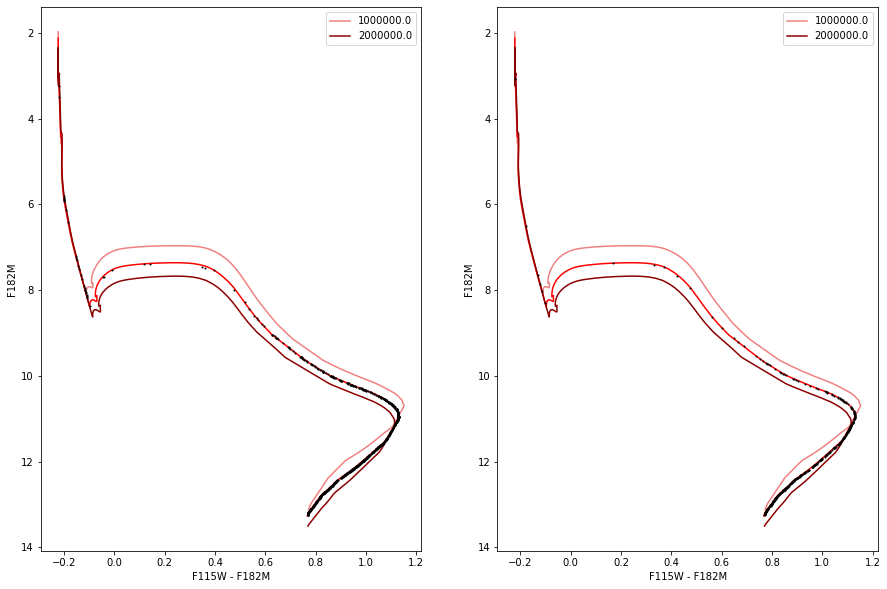

In [24]:
# plot primaries and companions separately
fig, axes = py.subplots(figsize=(15, 10))

# plot primaries
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# plot companions
py.subplot(1, 2, 2)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
        
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [25]:
# combine magnitudes on binary stars
unresolved_binaries = np.empty(len(companions), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None or companions[i] is None:
        continue
        
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.6e-8
    flux21 = np.power(10, companions[i][3] / -2.5) * 3.6e-8
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.6e-8)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 3.6e-8
    flux22 = np.power(10, companions[i][4] / -2.5) * 3.6e-8
    mag2 = -2.5 * np.log10((flux12 + flux22) / 3.6e-8)
    
    unresolved_binaries[i] = [mag1, mag2]

for i in range(len(unresolved_binaries)):
    print(unresolved_binaries[i])

[12.199240880159682, 11.184608530964091]
None
None
[11.839067264338496, 10.76979314053871]
None
None
None
[12.988322113458231, 12.182187543830565]
[10.398301299994845, 9.487822696021052]
[11.958657846627041, 10.908352862148432]
None
[12.664450848215107, 11.795507120620472]
None
[12.361776365575366, 11.394724120542943]
[11.95783699674584, 10.90659618538517]
None
None
None
None
None
[10.818529936659282, 9.803760646216169]
None
None
[12.015834430227954, 10.974050516952849]
None
[12.27467935885954, 11.294688777705106]
[12.685240275003986, 11.8209727624234]
None
None
[10.09314083190598, 9.27676465727519]
None
None
[12.477087451954525, 11.542366646124599]
None
None
None
None
None
[12.814784137823034, 11.972289278509793]
[13.014862261616525, 12.214572315047645]
[10.839093873772907, 9.775553456581012]
[11.506093873772906, 10.390555254432691]
None
None
[10.892950474964566, 9.813180248587997]
[11.312924895710797, 10.184424550323094]
None
None
None
None
None
None
[11.173536261681898, 10.062898887

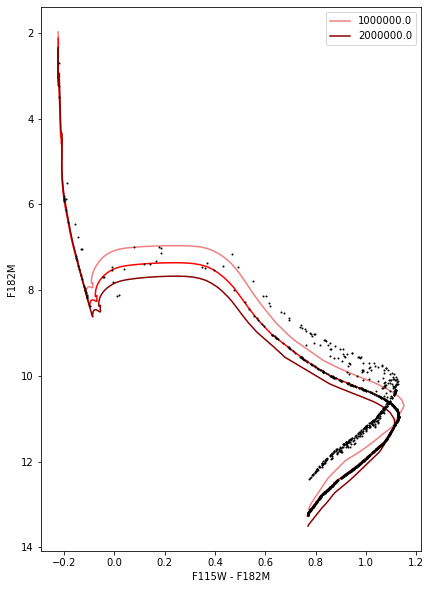

In [26]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
for i in range(len(unresolved_binaries)):
    if unresolved_binaries[i] is None:
        continue
    py.plot(unresolved_binaries[i][0] - unresolved_binaries[i][1], unresolved_binaries[i][1], marker='o', markersize=1, color='k')